# Invertible Concept-base Explanations

ICE(Invertible Concept-based Explanation) could generate class level and instance level explanations for a given pretrained model. 

## Initiallization

In [1]:
import os
os.chdir('/content')
CODE_DIR = 'InvertibleCE'
!git clone https://github.com/zhangrh93/InvertibleCE $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!pip install -r requirements.txt > installation_output.txt

Cloning into 'InvertibleCE'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 246 (delta 73), reused 209 (delta 39), pack-reused 0
Receiving objects: 100% (246/246), 12.91 MiB | 25.92 MiB/s, done.
Resolving deltas: 100% (73/73), done.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


ImageNet is too big and too hard for training. Here we will use torchvision [pretrained models](https://pytorch.org/vision/stable/models.html) and [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) to generate explanations.

In [2]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2021-07-04 17:08:28--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  83.6MB/s    in 10s     

2021-07-04 17:08:38 (75.8 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [3]:
!rm -r dataset
!mkdir dataset
!tar -xf images.tar -C ./dataset
!mv ./dataset/Images ./dataset/dogs
dog_list = os.listdir('dataset/dogs')
print(dog_list[:5],'...')
!wget https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt

rm: cannot remove 'dataset': No such file or directory
['n02105412-kelpie', 'n02085936-Maltese_dog', 'n02096294-Australian_terrier', 'n02101388-Brittany_spaniel', 'n02099267-flat-coated_retriever'] ...
--2021-07-04 17:08:41--  https://raw.githubusercontent.com/HoldenCaulfieldRye/caffe/master/data/ilsvrc12/synset_words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31675 (31K) [text/plain]
Saving to: ‘synset_words.txt’

synset_words.txt    100%[===================>]  30.93K  --.-KB/s    in 0.001s  

2021-07-04 17:08:42 (22.6 MB/s) - ‘synset_words.txt’ saved [31675/31675]



In [4]:

import ICE.Data
import ICE.ModelWrapper
import ICE.Explainer
import ICE.utils

import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import shutil
import os
from pathlib import Path

## Global explanations for one class



This includes the following steps:
1. Wrap the model with *get_feature*, *feature_predict*, and *predict* methods. When predicting, only target classes will be returned.
2. Provide a loader list (one loader per class) with data in form of (x,y)
3. Train the Explainer

### Parameters and Methods initialization

Stanford Dogs Dataset is a subset of the ImageNet. The only thing we need to do is to connect the classes from Stanford Dogs Dataset to ImageNet by class ID.

In [5]:
ImageNet_ID2idx = {}
ImageNet_idx2ID = []
with open('synset_words.txt','r') as f:
    for i,line in enumerate(f):
        tsplit = line.split('\n')[0].split(' ')
        ID = tsplit[0]
        name = ' '.join(tsplit[1:])
        #print (path,name)
        
        ImageNet_ID2idx[ID] = i
        ImageNet_idx2ID.append(ID)

fpath = Path('dataset') / 'dogs'
dog_paths = {d:fpath / d for d in dog_list}

dog_dict = {}
fpath = Path('dataset') / 'dogs'
dog_name2idx = {}

for i,k in enumerate(dog_paths.keys()):
  ID = k.split('-')[0]
  name = k.split('-')[1]
  if ID in ImageNet_idx2ID:
    dog_dict[ImageNet_ID2idx[ID]] = {'idx':ImageNet_ID2idx[ID],'ID':ID,'name':name,'path':fpath / k}
    dog_name2idx[k] = ImageNet_ID2idx[ID]
  #print (i,k,ID in ImageNet_idx2ID)


print ("5 dict samples:")
for d in ([dog_dict[k] for k in list(dog_dict.keys())[:5]] ):
  print (d)

print ()
  
paras = {}
paras['target_classes'] = [248]
paras['classes_names'] = ['dog']
paras['n_components'] = 10
paras['layer_name'] = 'layer4'
paras['title'] = "title"
paras['overwrite'] = False


5 dict samples:
{'idx': 227, 'ID': 'n02105412', 'name': 'kelpie', 'path': PosixPath('dataset/dogs/n02105412-kelpie')}
{'idx': 153, 'ID': 'n02085936', 'name': 'Maltese_dog', 'path': PosixPath('dataset/dogs/n02085936-Maltese_dog')}
{'idx': 193, 'ID': 'n02096294', 'name': 'Australian_terrier', 'path': PosixPath('dataset/dogs/n02096294-Australian_terrier')}
{'idx': 215, 'ID': 'n02101388', 'name': 'Brittany_spaniel', 'path': PosixPath('dataset/dogs/n02101388-Brittany_spaniel')}
{'idx': 205, 'ID': 'n02099267', 'name': 'flat', 'path': PosixPath('dataset/dogs/n02099267-flat-coated_retriever')}



Here we define the loader list generate function and explainer training function.

In [6]:


def make_imgs(paths = [],labels = []):
    imgs = []
    for i,path in enumerate(paths):
        imgs += [(os.path.join(path,t),labels[i]) for t in os.listdir(path)]
    return imgs

def get_loaders(target_classes = []):
  loaders = []
  for i,idx in enumerate(target_classes):
    loaders.append(DataLoader(
            ICE.Data.ImageDataset(make_imgs([dog_dict[idx]['path']],[i]),
                    transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]),
                    ])),
            batch_size = 16,
            num_workers=2,
            #shuffle=True
    ))
  return loaders


def get_explainer(paras,model):
  classes_names = paras['classes_names']
  target_classes = paras['target_classes']
  n_components = paras['n_components']
  layer_name = paras['layer_name'] 
  title = paras['title']
  overwrite = paras['overwrite']

  if overwrite:
    try:
        shutil.rmtree('Explainers/'+title)
    except:
        pass
  
  model.set_predict_target(target_classes)
  loaders = get_loaders(target_classes)
  if os.path.exists(Path('Explainers')/title):
    Exp = ICE.Explainer.Explainer(title = title)
    Exp.load()
    print ('model loaded')
  else:

    # create an Explainer
    Exp = ICE.Explainer.Explainer(title = title,
                    layer_name = layer_name,
                    class_names = classes_names,
                    utils = ICE.utils.img_utils(mode = "torch"),
                    n_components = n_components,
                    reducer_type = "NMF"
                  )

    # train reducer based on target classes
    Exp.train_model(model,loaders)
    # generate features 
    Exp.generate_features(model, loaders)
    # generate global explanations
    Exp.global_explanations()
    # save the explainer, use load to load it with the same title
    Exp.save()

  return Exp

m = models.resnet50(pretrained=True)
m = m.cuda()
m.eval()
model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=16,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


### ICE Explainer for one class

Here we can change the parameters for different concept-based explanations.

The whole training phase may take about one minutes.

Fidelity error is a good evaluation metric for explanations. Based on our previous experiences, 5% to 10% is a good value range.

In [7]:
from IPython.display import display, Image
import ipywidgets as widgets
import os
from pathlib import Path

#@title { display-mode: "form", run: "auto" }

target_class = 'n02109961-Eskimo_dog' #@param ['n02105412-kelpie', 'n02085936-Maltese_dog', 'n02096294-Australian_terrier', 'n02101388-Brittany_spaniel', 'n02099267-flat-coated_retriever', 'n02088364-beagle', 'n02099429-curly-coated_retriever', 'n02097474-Tibetan_terrier', 'n02102318-cocker_spaniel', 'n02108089-boxer', 'n02108000-EntleBucher', 'n02094433-Yorkshire_terrier', 'n02090379-redbone', 'n02102040-English_springer', 'n02101006-Gordon_setter', 'n02107312-miniature_pinscher', 'n02093647-Bedlington_terrier', 'n02091244-Ibizan_hound', 'n02112350-keeshond', 'n02097047-miniature_schnauzer', 'n02094258-Norwich_terrier', 'n02088238-basset', 'n02110627-affenpinscher', 'n02098413-Lhasa', 'n02094114-Norfolk_terrier', 'n02087046-toy_terrier', 'n02115913-dhole', 'n02105505-komondor', 'n02107142-Doberman', 'n02099601-golden_retriever', 'n02093859-Kerry_blue_terrier', 'n02107574-Greater_Swiss_Mountain_dog', 'n02100583-vizsla', 'n02105251-briard', 'n02098286-West_Highland_white_terrier', 'n02107683-Bernese_mountain_dog', 'n02088466-bloodhound', 'n02105162-malinois', 'n02110806-basenji', 'n02087394-Rhodesian_ridgeback', 'n02106662-German_shepherd', 'n02097209-standard_schnauzer', 'n02111129-Leonberg', 'n02111500-Great_Pyrenees', 'n02100877-Irish_setter', 'n02090721-Irish_wolfhound', 'n02097130-giant_schnauzer', 'n02113978-Mexican_hairless', 'n02093256-Staffordshire_bullterrier', 'n02113624-toy_poodle', 'n02092339-Weimaraner', 'n02096051-Airedale', 'n02116738-African_hunting_dog', 'n02096437-Dandie_Dinmont', 'n02102973-Irish_water_spaniel', 'n02100735-English_setter', 'n02096177-cairn', 'n02095570-Lakeland_terrier', 'n02113712-miniature_poodle', 'n02107908-Appenzeller', 'n02098105-soft-coated_wheaten_terrier', 'n02109961-Eskimo_dog', 'n02085620-Chihuahua', 'n02093428-American_Staffordshire_terrier', 'n02088632-bluetick', 'n02086240-Shih-Tzu', 'n02091134-whippet', 'n02106030-collie', 'n02105855-Shetland_sheepdog', 'n02093754-Border_terrier', 'n02093991-Irish_terrier', 'n02102480-Sussex_spaniel', 'n02089973-English_foxhound', 'n02111889-Samoyed', 'n02089867-Walker_hound', 'n02091831-Saluki', 'n02091635-otterhound', 'n02106166-Border_collie', 'n02097298-Scotch_terrier', 'n02086646-Blenheim_spaniel', 'n02106382-Bouvier_des_Flandres', 'n02109525-Saint_Bernard', 'n02095889-Sealyham_terrier', 'n02101556-clumber', 'n02110063-malamute', 'n02113799-standard_poodle', 'n02111277-Newfoundland', 'n02086910-papillon', 'n02110958-pug', 'n02105056-groenendael', 'n02088094-Afghan_hound', 'n02089078-black-and-tan_coonhound', 'n02104029-kuvasz', 'n02099712-Labrador_retriever', 'n02108422-bull_mastiff', 'n02091032-Italian_greyhound', 'n02105641-Old_English_sheepdog', 'n02091467-Norwegian_elkhound', 'n02112018-Pomeranian', 'n02086079-Pekinese', 'n02100236-German_short-haired_pointer', 'n02108551-Tibetan_mastiff', 'n02112706-Brabancon_griffon', 'n02113023-Pembroke', 'n02099849-Chesapeake_Bay_retriever', 'n02090622-borzoi', 'n02109047-Great_Dane', 'n02106550-Rottweiler', 'n02096585-Boston_bull', 'n02097658-silky_terrier', 'n02108915-French_bulldog', 'n02113186-Cardigan', 'n02104365-schipperke', 'n02110185-Siberian_husky', 'n02115641-dingo', 'n02085782-Japanese_spaniel', 'n02092002-Scottish_deerhound', 'n02112137-chow', 'n02102177-Welsh_springer_spaniel', 'n02095314-wire-haired_fox_terrier']
classes_names = [target_class]
target_classes = [dog_name2idx[target_class]]
n_components = 10 #@param {type:"slider", min:5, max:30, step:5}
layer_name = 'layer4' #@param ['layer1', 'layer2', 'layer3', 'layer4']
overwrite = False #@param {type:"boolean"}
title = "{}_{}_{}_{}".format(target_classes,classes_names,n_components,layer_name)

paras = {}
paras['classes_names'] = classes_names
paras['target_classes'] = target_classes
paras['n_components'] = n_components
paras['layer_name'] = layer_name
paras['title'] = title
paras['overwrite'] = overwrite

for k,v in paras.items():
  print (k,':',v)

button = widgets.Button(description="Get Explanations!")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    Exp = get_explainer(paras,model)
    fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
    display(Image(str(fpath/os.listdir(fpath)[0])))

button.on_click(on_button_clicked)
display(button, output)

classes_names : ['n02109961-Eskimo_dog']
target_classes : [248]
n_components : 10
layer_name : layer4
title : [248]_['n02109961-Eskimo_dog']_10_layer4
overwrite : False


Button(description='Get Explanations!', style=ButtonStyle())

Output()

## Local explanations for explainer targeting two classes

Next, we will train an explainer telling you a `why dog but not cat' question. Using classes '243 bull mastiff' and '282 tiger cat'.

Here only parameter settings and final results will be displayed.

### Parameter initialization

Similar to previous part, we need to set some parameters to the model.

Targeting two classes, target_classes and classes_names will contain two class indexes and names.

In [8]:

target_classes = [243,282]
classes_names = ['dogs','cats']
title = "dogcat"
n_components = 10
layer_name = 'layer4'

print ("title:{}".format(title))
print ("target_classes:{}".format(target_classes))
print ("classes_names:{}".format(classes_names))
print ("n_components:{}".format(n_components))
print ("layer_name:{}".format(layer_name))

title:dogcat
target_classes:[243, 282]
classes_names:['dogs', 'cats']
n_components:10
layer_name:layer4


Also, we need a loader list contains loader for each class prviding data in form of (X,y).

Model wrapper will wrap the resnet50 model from torchvision.

In [ ]:
'''
loaders = [DataLoader(
        ICE.Data.ImageDataset(make_imgs([#img folder path],[label]),
                transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
                ])),
        batch_size = 16,
        num_workers=8,
        #shuffle=True
) for label in target_classes]


m = models.resnet50(pretrained=True)
m = m.cuda()
m.eval()
model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=16,predict_target=target_classes,input_channel_first = False,model_channel_first = True)
'''

### Explainer training

Everything is the same other than a modification for class_names and target_classes for model wrapper.

In [ ]:
'''
print ("-------------------------------------------------------------------------------------------")

try:
    shutil.rmtree('Explainers/'+title)
except:
    pass
# create an Explainer
Exp = ICE.Explainer.Explainer(title = title,
                layer_name = layer_name,
                class_names = classes_names,
                utils = ICE.utils.img_utils(mode = "torch"),
                n_components = n_components,
                reducer_type = "NMF"
               )

# train reducer based on target classes
Exp.train_model(model,loaders)
# generate features 
Exp.generate_features(model, loaders)
# generate global explanations
Exp.global_explanations()
# save the explainer, use load to load it with the same title
Exp.save()
'''

### Generate local explanations

For local explanations, we need to load the instance and fit it to the explainer with Exp.local_explanations(x,model).

(224, 224, 3)


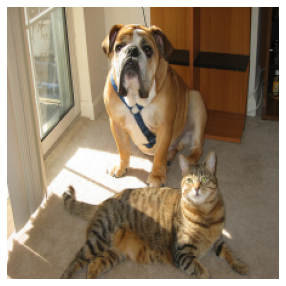

In [11]:
# generate local explanation for catdog.png
from PIL import Image
u1 = ICE.utils.img_utils(mode = "torch")
img_path = "catdog.png"
img = Image.open(img_path).convert("RGB")
x = transforms.ToTensor()(transforms.Resize(u1.fsize)(img))
x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()
x = np.transpose(x,(1,2,0)) #to channel_last
print (x.shape)

'''
#We skip this line since that we did not really train the explainer.
Exp.local_explanations(x,model)
'''

u1.show_img([x])

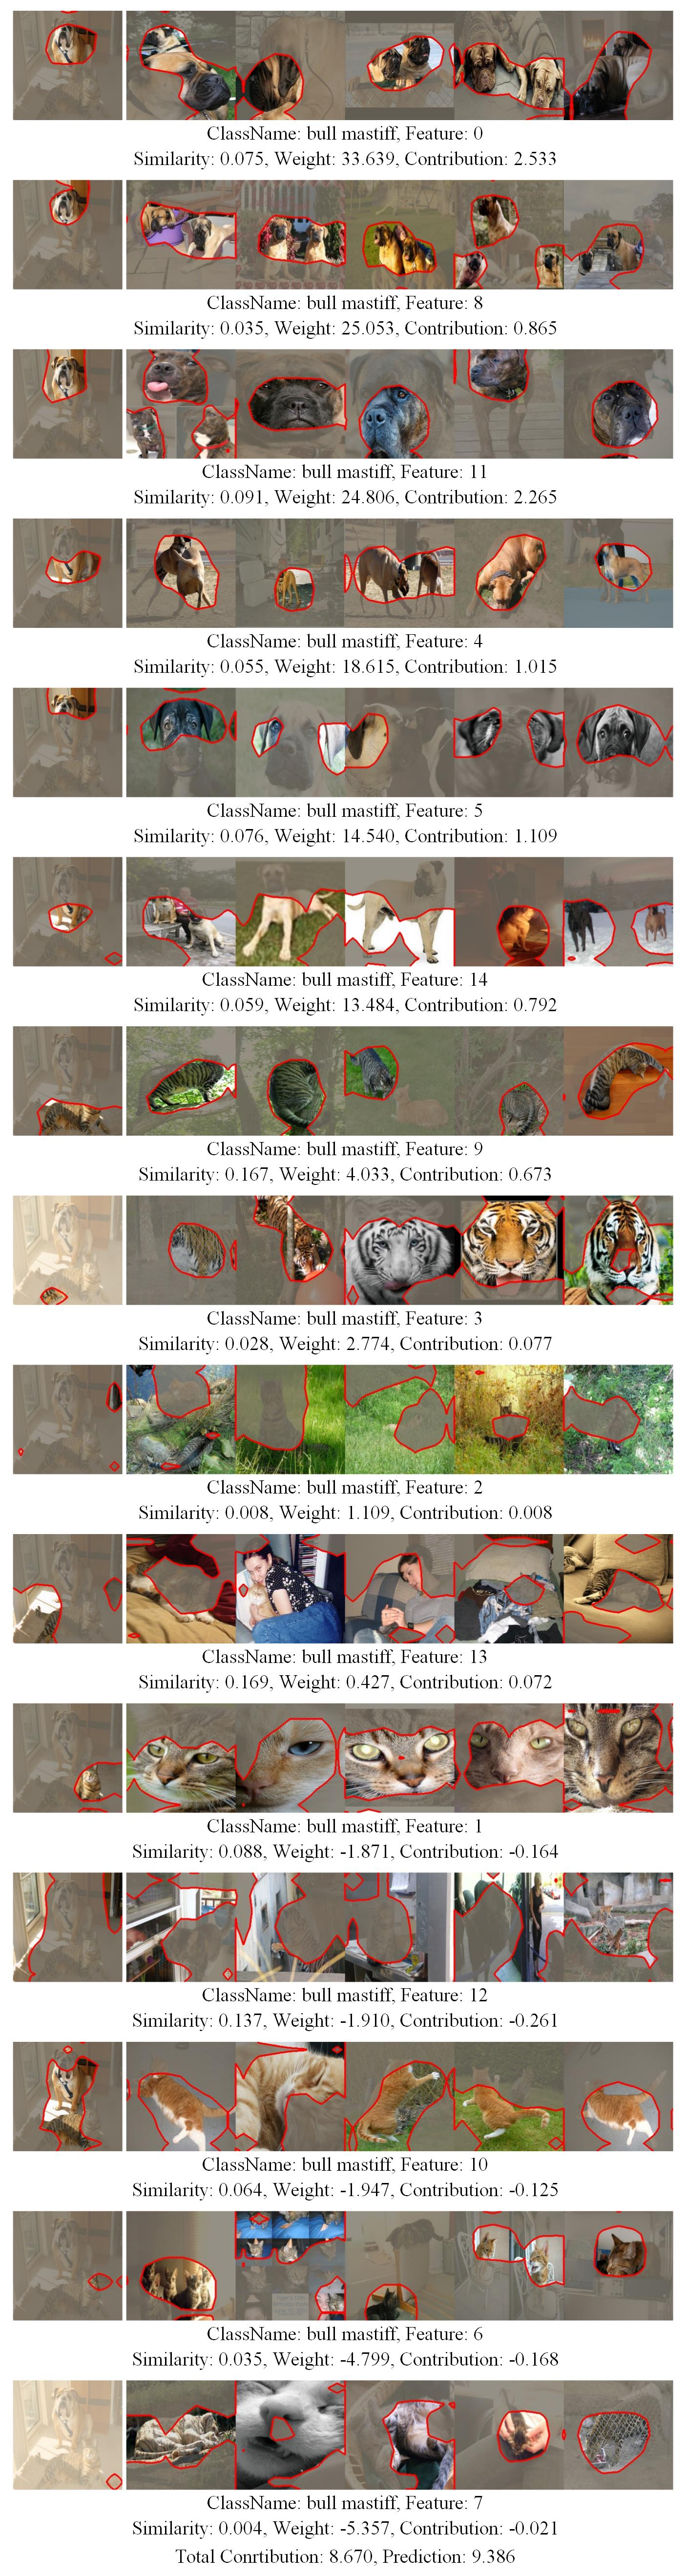

In [12]:
from IPython.display import display, Image
import os
fpath = Path("Explainers") / title / "explanations" / "all"
fname = '0_243.jpg' #@param ['0_243.jpg', '0_282.jpg']

display(Image(str(fpath / fname)))